# Table of Contents

* [Data Prep](#data-prep)
* [Experiments on 1 Time Series](#Experiments-on-1-Time-Series)
* [Models](#Models)
    - [ARMA with No Covariates](#ARMA-with-No-Covariates)
    - [OLS 1: Weekday](#ols-1)
    - [OLS 2: OLS 1 + Lags](#ols-2-lags)
    - [OLS 3: OLS 2 + Oil](#ols-3-oil)
    - [ARMA with Covariates](#ARMA-with-Covariates)
    - [OLS 4: OLS 3 + Month + Holidays + Promotions](#OLS-4)
    - [Hybrid Model (OLS + Random Forest)](#hybrid)
    - [Expansion to Full Dataset](#full)

* [Conclusion](#section-three)

In [499]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [500]:
!pip3 install impyute

In [501]:
!pip install pmdarima

In [502]:
from impyute.imputation.ts import locf

from datetime import date, timedelta

from pmdarima.arima import auto_arima

In [503]:
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import acf, pacf

import statsmodels.api as sm

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.stats.stattools import durbin_watson

from sklearn.linear_model import RidgeCV

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV


pd.set_option('display.max_columns', 100)

<a id="data-prep"></a>
# Data Prep

In [504]:
ls ../input/store-sales-time-series-forecasting/

holidays_events.csv  sample_submission.csv  test.csv   transactions.csv
oil.csv              stores.csv             train.csv


In [505]:
train = pd.read_csv('../input/store-sales-time-series-forecasting/train.csv')
test = pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')
transactions = pd.read_csv("../input/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])
oil = pd.read_csv('../input/store-sales-time-series-forecasting/oil.csv')
sample_submission = pd.read_csv('../input/store-sales-time-series-forecasting/sample_submission.csv')
holiday_events = pd.read_csv('../input/store-sales-time-series-forecasting/holidays_events.csv', parse_dates=['date'], infer_datetime_format=True)

In [506]:
#pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')

In [507]:
#format dates
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
holiday_events['date'] = pd.to_datetime(holiday_events.date)



In [508]:
train.index = train['date']
test.index = test['date']

In [509]:
#holiday_events
holiday_events['date'] = holiday_events['date'].replace({'2013-04-29' : 
                                         pd.to_datetime('2013-03-29')}) # 'Good Friday' mistake correction
holiday_events = holiday_events.set_index('date').sort_index()

holiday_events = holiday_events[holiday_events.locale == 'National'] # National level only for simplicity

holiday_events = holiday_events.groupby(holiday_events.index).first() # Keep one event only

### Holidays

In [510]:
train['nye'] = train['date'].apply(lambda x: 1 if (x.month == 1) and (x.day == 1) else 0)
test['nye'] = test['date'].apply(lambda x: 1 if (x.month == 1) and (x.day == 1) else 0)

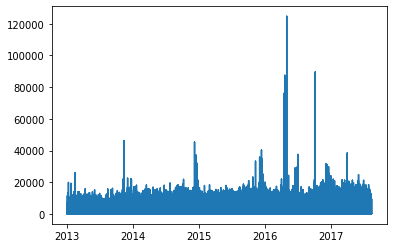

In [511]:
plt.plot(train['date'],train['sales'])

### Weekdays

In [512]:
train['day_of_week'] = [x.day_of_week for x in train['date']]
test['day_of_week'] = [x.day_of_week for x in test['date']]


In [513]:
def create_dow(x):
    if x == 0:
        return('Sun')
    elif x == 1:
        return('Mon')
    elif x == 2:
        return('Tues')
    elif x == 3:
        return('Weds')
    elif x == 4:
        return('Thurs')
    elif x == 5:
        return('Fri')
    elif x == 6:
        return('Sat')

In [514]:
train['day_of_week'] = train['day_of_week'].apply(lambda x: create_dow(x))
test['day_of_week'] = test['day_of_week'].apply(lambda x: create_dow(x))

In [515]:
train = pd.concat([train.drop('day_of_week', axis=1), 
           pd.get_dummies(train['day_of_week'], drop_first=True)], axis=1)

test = pd.concat([test.drop('day_of_week', axis=1), 
           pd.get_dummies(test['day_of_week'], drop_first=True)], axis=1)

### Lags

In [516]:
train = train.sort_values(['store_nbr','family'])

In [517]:
train['lag1'] = train.shift(periods=1)['sales']
train['lag2'] = train.shift(periods=2)['sales']
train['lag3'] = train.shift(periods=3)['sales']
train['lag4'] = train.shift(periods=4)['sales']
train['lag5'] = train.shift(periods=5)['sales']
train['lag6'] = train.shift(periods=6)['sales']
train['lag7'] = train.shift(periods=7)['sales']
train['lag8'] = train.shift(periods=8)['sales']

In [518]:
train = train.loc['2013-01-10':'2017-08-15']

In [519]:
test = test.merge(train[train['date'] == '2017-08-15'][['lag1','lag2','lag3','lag4','lag5',
                                                     'lag6','lag7','family','store_nbr']],
                 how='inner', left_on=['family','store_nbr'], right_on=['family','store_nbr'])

In [520]:
test.index = test['date']

### Oil

In [521]:
oil['date'] = pd.to_datetime(oil['date'])

all_dates = pd.date_range(oil['date'][0],
              oil['date'][1217]-timedelta(days=1),freq='d')

oil.index = oil['date']

oil = oil['dcoilwtico']

all_dates = pd.DataFrame(all_dates, index=all_dates)

oil = pd.DataFrame(all_dates).join(oil, how='left')['dcoilwtico']

oil = locf(np.array([oil]))

oil = pd.DataFrame(data = oil, index = all_dates.index)

oil.columns = ['oil']

oil.index.name = 'date'

/opt/conda/lib/python3.7/site-packages/impyute/util/checks.py:53: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return data.dtype == np.float


In [522]:
oil = oil.append(pd.DataFrame(data={'oil': [45.96], 'date': ['2017-08-30'], 'month': [8]},
            index=pd.DatetimeIndex(['2017-08-31'])))

In [523]:


#train.index = train.index.to_timestamp()

train = train.merge(oil, how='inner', left_index=True, right_index=True)

In [524]:
test = test.merge(oil, how='inner', left_index=True, right_index=True)

### Month + Wage Day

In [525]:
month_df = oil

month_df['date'] = month_df.index 

month_df['month'] = month_df['date'].apply(lambda x: str(x.month))

month_df = pd.get_dummies(month_df, drop_first=True)

month_df = month_df.drop(['oil','date'],axis=1)


In [526]:
train = train.merge(month_df, how='inner', left_index=True, right_index=True)
test = test.merge(month_df, how='inner', left_index=True, right_index=True)

In [532]:
train['date'] = train['date_x']
test['date'] = test['date_x']

train = train.drop(['date_x','date_y'], axis=1)
test = test.drop(['date_x','date_y'], axis = 1)

In [533]:
train["wageday"] = train['date'].apply(lambda x: 1 if x.day in [1,15] else 0)
test['wageday'] = test['date'].apply(lambda x: 1 if x.day in [1,15] else 0)

### Holidays

In [534]:
#day after New Years - spike on this date
train['day_after_ny'] = train['date'].apply(lambda x: 1 if (x.month == 1) and (x.day == 2) else 0)
test['day_after_ny'] = test['date'].apply(lambda x: 1 if (x.month == 1) and (x.day == 2) else 0)

In [535]:
#Christmas

#christmas is missing from the dataset
#train['christmas'] = train['date'].apply(lambda x: 1 if (x.month == 12) and (x.day == 25) else 0)


#Black Friday
black_friday_dates = holiday_events[holiday_events['description'].isin(['Black Friday'])].index

train['black_friday'] = train['date'].apply(lambda x: 1 if x in black_friday_dates else 0)
test['black_friday'] = test['date'].apply(lambda x: 1 if x in black_friday_dates else 0)


#Cyber Monday
cyber_monday_dates = holiday_events[holiday_events['description'].isin(['Cyber Monday'])].index

train['cyber_monday'] = train['date'].apply(lambda x: 1 if x in cyber_monday_dates else 0)
test['cyber_monday'] = test['date'].apply(lambda x: 1 if x in cyber_monday_dates else 0)


#Carnaval
carnaval_dates = holiday_events[holiday_events['description'].isin(['Carnaval'])].index

train['carnaval'] = train['date'].apply(lambda x: 1 if x in carnaval_dates else 0)
test['carnaval'] = test['date'].apply(lambda x: 1 if x in carnaval_dates else 0)

In [536]:
other_holiday_dates = holiday_events[holiday_events['description'].isin(['Primer Grito de Independencia',
            'Dia de Difuntos','Independencia de Cuenca',
               'Independencia de Guayaquil','Batalla de Pichinca','Dia de la Madre-1',
                'Dia del Trabajo','Viernes Santo','Traslado Independencia de Guayaquil',
                'Traslado Primer Grito de Independencia','Traslado Batalla de Pichincha'])].index

train['other_holiday'] = train['date'].apply(lambda x: 1 if x in other_holiday_dates else 0)
test['other_holiday'] = test['date'].apply(lambda x: 1 if x in other_holiday_dates else 0)

New columns: 'wageday','day_after_ny','christmas','black_friday','cyber_monday','carnaval','other_holiday'

### Promotions

Already formatted (although you'll need to aggregate it for sum of stores)

<a id="Experiments-on-1-Time-Series"></a>
# Experiments on 1 Time Series

In [537]:
unique_ts = len(np.unique(train['store_nbr'])) * len(np.unique(train['family']))

print('Number of unique time series (stores * families): ' + str(unique_ts))

Number of unique time series (stores * families): 1782


Here, we choose 1 time series to experiment on out of the 1782 available data streams to speed up our iterative process of trying out new models.

In [538]:
np.unique(train['family'])

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [539]:
#Choose smaller df
df = train[(train['store_nbr'] == 10) & (train['family'] == 'PERSONAL CARE')]

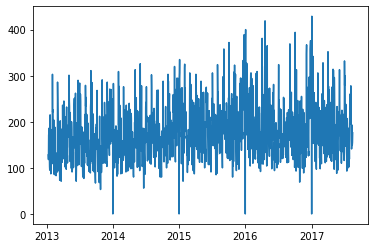

In [540]:
plt.plot(df['date'], df['sales'].reset_index(drop=True))

Some stores are missing data for certain products and not for others.

We further shrink it to a train set of the year of pre-2016 and test set of 2017 to ease the experimental process further

In [541]:
#Choose a smaller date range
df_train = df[df['date'].copy().apply(lambda x: x.year) <= 2016]

df_test = df[df['date'].copy().apply(lambda x: x.year) >= 2017]

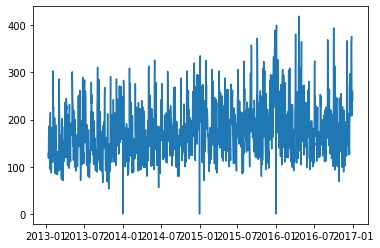

In [542]:
#Sales over time for the select time, store, and type data stream

plt.plot(df_train['date'], df_train['sales'].reset_index(drop=True))

<a id="Models"></a>

# Models

In [543]:
df_train.index = pd.DatetimeIndex(df_train['date']).to_period("D")

In [544]:
df_test.index = pd.DatetimeIndex(df_test['date']).to_period("D")

<a id="ARMA-with-No-Covariates"></a>
### ARMA with No Covariates

Here, we try a bunch of different ARMA models on the time series and see which have the best AIC on the training set and RMSE on the test set.  We select the model with the best value for these metrics to do further work on.  Here, it looks like the ARMA(2,2) model has the best test RMSE out of all these models.  Let's take a closer look at that model.

In [545]:
#making this smaller to speed runtime
for p in np.array([0]):
    for q in np.array([0]):
        arima_model = ARIMA(df_train['sales'], order=(p,0,q)).fit()
        
        y_preds = arima_model.predict(df_test['date'].iloc[0], df_test['date'].iloc[89])

        resids = np.array(df_test['sales'][:90]) - np.array(y_preds)
        
        test_rmse = np.sqrt(np.sum(resids**2)/len(resids))
        
        
        train_rmse = np.sqrt(np.sum(arima_model.resid**2)/len(df_train))
        
            
        print('AR: ' + str(p) + ', MA:' + str(q) + ', AIC: ' + str(arima_model.aic) + 
             ', Test RMSE: ' + str(test_rmse) + ', Train RMSE: ' + str(train_rmse))

AR: 0, MA:0, AIC: 15922.062979021066, Test RMSE: 64.60667270536159, Train RMSE: 59.005469117748355


We will predict without including New Years, as the stores are closed on New Years and that fact is not (yet) incorporated into our model.  We'll get more pinpoint visualizations and ideas of how are model is doing if we exclude that date for now and focus on more regular time series, and come back to address the New Years problem later.

In [546]:
#ARMA(2,2) model with no covariates
arima_model = ARIMA(df_train['sales'], order=(0,0,8)).fit()
        
y_preds = arima_model.predict(df_test['date'].iloc[0], df_test['date'].iloc[89])

resids = np.array(df_test['sales'][0:90]) - np.array(y_preds)
        
test_rmse = np.sqrt(np.sum(resids**2)/len(resids))

print('Test RMSE: ' + str(test_rmse))

Test RMSE: 63.77794471190894


In [547]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1448
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7639.345
Date:                Mon, 02 Jan 2023   AIC                          15298.690
Time:                        21:53:13   BIC                          15351.469
Sample:                    01-10-2013   HQIC                         15318.387
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.4565      4.079     43.505      0.000     169.462     185.451
ma.L1          0.4889      0.019     25.282      0.000       0.451       0.527
ma.L2          0.2554      0.025     10.108      0.000       0.206       0.305
ma.L3          0.1880      0.028      6.602      0.000       0.132       0.244
ma.L4          0.1601      0.030      5.282      0.000       0.101       0.220
ma.L5          0.1069      0.030      3.570      0.000       0.048       0.166
ma.L6          0.0638      0.028      2.277      0.023       0.009       0.119
ma.L7          0.3936      0.027     14.314      0.000       0.340       0.448
ma.L8          0.1731      0.027      6.423      0.000       0.120       0.226
sigma2      2236.6394     68.732     32.542      0.000    2101.928    2371.351
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):               319.76
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.43   Skew:                             0.68
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

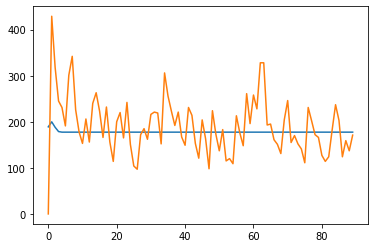

In [548]:
plt.plot(y_preds.values)

plt.plot(df_test['sales'].values[0:90])

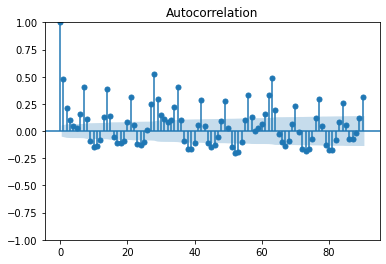

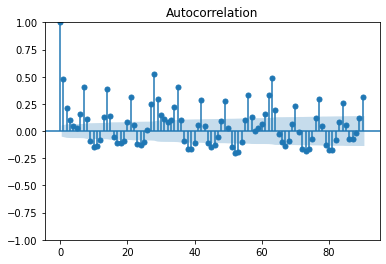

In [549]:
sm.graphics.tsa.plot_acf(df_train['sales'], lags=90)

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


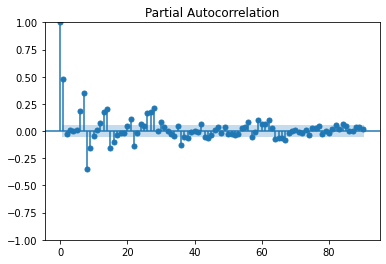

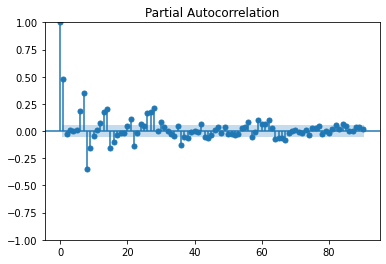

In [550]:
sm.graphics.tsa.plot_pacf(df_train['sales'], lags=90)

<a id="ols-1"></a>
## OLS With Weekday Dummies + NY + Time Trend

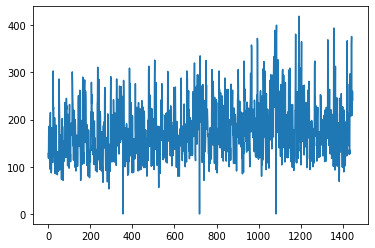

In [551]:
plt.plot(df_train['sales'].reset_index(drop=True))

In [552]:
df_train['Trend'] = [x for x in range(0,len(df_train['sales']))]
df_test['Trend'] = [x for x in range(len(df_train['sales']),
                                         len(df_train['sales']) + len(df_test['sales']))]


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [553]:
ols_weekday_cols = ['Trend','Mon','Tues','Weds','Thurs','Sat','Sun','nye']

In [554]:
ols_mod = sm.OLS(df_train['sales'], 
                 sm.add_constant(df_train[ols_weekday_cols]),
                hasconst=True).fit()

In [555]:
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.415
Method:                 Least Squares   F-statistic:                     129.3
Date:                Mon, 02 Jan 2023   Prob (F-statistic):          2.77e-163
Time:                        21:53:14   Log-Likelihood:                -7566.9
No. Observations:                1448   AIC:                         1.515e+04
Df Residuals:                    1439   BIC:                         1.520e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        206.7325      3.746     55.183      0.000     199.384     214.081
Trend          0.0311      0.003     10.963      0.000       0.026       0.037
Mon          -49.4905      4.433    -11.165      0.000     -58.186     -40.795
Tues         -74.0119      4.440    -16.670      0.000     -82.721     -65.303
Weds         -81.4554      4.434    -18.369      0.000     -90.154     -72.757
Thurs       -100.0888      4.434    -22.571      0.000    -108.787     -91.390
Sat           -5.1751      4.438     -1.166      0.244     -13.881       3.531
Sun          -50.4014      4.433    -11.371      0.000     -59.096     -41.706
nye         -143.9222     26.130     -5.508      0.000    -195.180     -92.665
==============================================================================
Omnibus:                      154.170   Durbin-Watson:                   0.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              215.181
Skew:                           0.816   Prob(JB):                     1.88e-47
Kurtosis:                       3.951   Cond. No.                     1.84e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [556]:
y_preds = ols_mod.predict(sm.add_constant(df_test[ols_weekday_cols])[:90])

resids = np.array(df_test['sales'][0:90]) - np.array(y_preds)
        
test_rmse = np.sqrt(np.sum(resids**2)/len(resids))

In [557]:
test_rmse

53.08195393045698

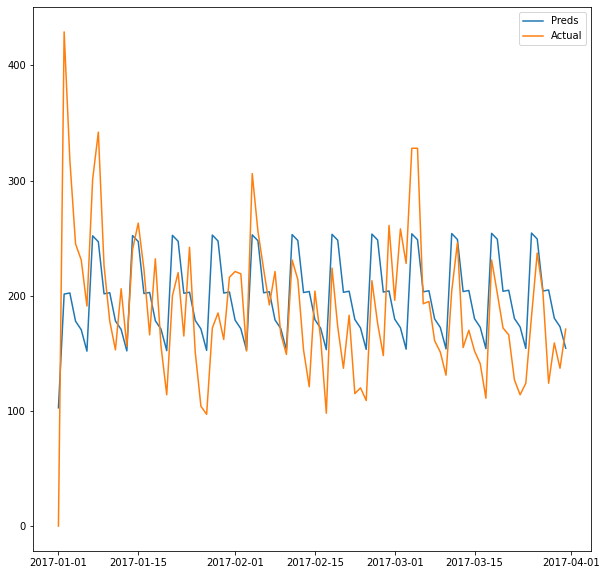

In [558]:
plt.figure(figsize=(10,10))

plt.plot(df_test['date'][:90], y_preds.values, label='Preds')

plt.plot(df_test['date'][:90], df_test['sales'].values[0:90], label='Actual')

plt.legend()

<a id="ols-2-lags"></a>
## OLS 2: OLS 1 + Lags

In [559]:
lags_dow_cols = ['Trend','Mon','Tues','Weds','Thurs',
                'Sat','Sun','lag1','lag2','lag3','lag4','lag5',
                'lag6','lag7','nye']

In [560]:
ols_mod = sm.OLS(df_train['sales'], 
                 sm.add_constant(df_train[lags_dow_cols]),
                hasconst=True).fit()

In [561]:
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     168.2
Date:                Mon, 02 Jan 2023   Prob (F-statistic):          1.18e-302
Time:                        21:53:14   Log-Likelihood:                -7223.4
No. Observations:                1448   AIC:                         1.448e+04
Df Residuals:                    1432   BIC:                         1.456e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        138.3652      5.979     23.142      0.000     126.637     150.093
Trend          0.0111      0.002      4.575      0.000       0.006       0.016
Mon          -94.9546      4.900    -19.377      0.000    -104.567     -85.342
Tues        -115.0793      4.816    -23.893      0.000    -124.527    -105.631
Weds        -105.6934      5.057    -20.901      0.000    -115.613     -95.774
Thurs       -106.5013      4.624    -23.031      0.000    -115.572     -97.430
Sat          -49.6396      4.690    -10.584      0.000     -58.840     -40.439
Sun         -108.2387      4.734    -22.864      0.000    -117.525     -98.952
lag1           0.4572      0.026     17.700      0.000       0.407       0.508
lag2           0.1713      0.028      6.069      0.000       0.116       0.227
lag3           0.0748      0.028      2.627      0.009       0.019       0.131
lag4           0.0306      0.028      1.076      0.282      -0.025       0.087
lag5          -0.0348      0.028     -1.232      0.218      -0.090       0.021
lag6          -0.0820      0.028     -2.929      0.003      -0.137      -0.027
lag7           0.0268      0.026      1.047      0.295      -0.023       0.077
nye         -165.1215     20.910     -7.897      0.000    -206.138    -124.105
==============================================================================
Omnibus:                      265.512   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              683.488
Skew:                           0.976   Prob(JB):                    3.82e-149
Kurtosis:                       5.742   Cond. No.                     2.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [562]:
y_preds = ols_mod.predict(sm.add_constant(df_test[lags_dow_cols][0:90]))

resids = np.array(df_test['sales'][0:90]) - np.array(y_preds)
        
test_rmse = np.sqrt(np.sum(resids**2)/len(resids))

In [563]:
test_rmse

50.68952632328057

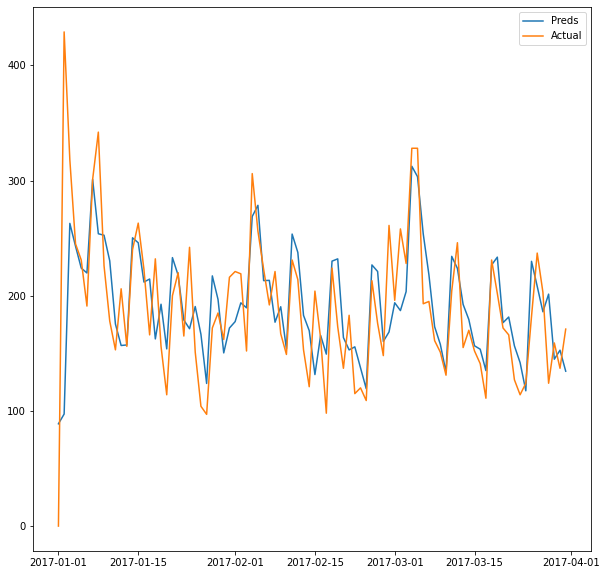

In [564]:
plt.figure(figsize=(10,10))

plt.plot(df_test.index[0:90].to_timestamp(), y_preds.values, label='Preds')

plt.plot(df_test.index[0:90].to_timestamp(), df_test['sales'].values[0:90], label='Actual')

plt.legend()

<a id="ols-3-oil"></a>
## OLS 3: OLS 2 + Oil

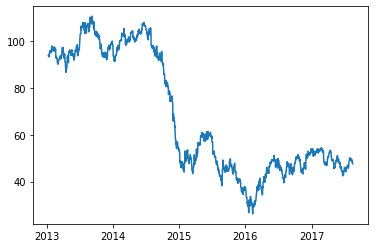

In [565]:
plt.plot(train['oil'])

In [566]:
np.corrcoef(df_train['sales'], df_train['oil'])

array([[ 1.        , -0.24474632],
       [-0.24474632,  1.        ]])

#### Effect of Oil on Overall Sales (Detectable Effect)

In [567]:
oil_cols = ['Trend','Mon','Tues','Weds',
                'Thurs','Sat','Sun','lag1','lag2','lag3','lag4','lag5',
                'lag6','lag7','nye','oil']

In [568]:
ols_mod = sm.OLS(df_train['sales'], 
                 sm.add_constant(df_train[oil_cols]),
                hasconst=True).fit()

In [569]:
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.640
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     158.9
Date:                Mon, 02 Jan 2023   Prob (F-statistic):          4.36e-303
Time:                        21:53:15   Log-Likelihood:                -7219.7
No. Observations:                1448   AIC:                         1.447e+04
Df Residuals:                    1431   BIC:                         1.456e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        163.2688     11.026     14.808      0.000     141.641     184.897
Trend          0.0008      0.005      0.185      0.853      -0.008       0.010
Mon          -95.0285      4.890    -19.434      0.000    -104.620     -85.437
Tues        -115.3572      4.807    -23.997      0.000    -124.787    -105.927
Weds        -106.0777      5.048    -21.014      0.000    -115.980     -96.175
Thurs       -106.8703      4.616    -23.151      0.000    -115.926     -97.815
Sat          -49.4500      4.681    -10.565      0.000     -58.631     -40.269
Sun         -108.1332      4.724    -22.891      0.000    -117.400     -98.867
lag1           0.4527      0.026     17.527      0.000       0.402       0.503
lag2           0.1688      0.028      5.990      0.000       0.114       0.224
lag3           0.0735      0.028      2.586      0.010       0.018       0.129
lag4           0.0297      0.028      1.043      0.297      -0.026       0.085
lag5          -0.0362      0.028     -1.284      0.199      -0.092       0.019
lag6          -0.0847      0.028     -3.030      0.002      -0.140      -0.030
lag7           0.0210      0.026      0.819      0.413      -0.029       0.071
nye         -165.1822     20.864     -7.917      0.000    -206.110    -124.254
oil           -0.1974      0.073     -2.686      0.007      -0.342      -0.053
==============================================================================
Omnibus:                      263.416   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              675.326
Skew:                           0.970   Prob(JB):                    2.26e-147
Kurtosis:                       5.726   Cond. No.                     2.11e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [570]:
y_preds = ols_mod.predict(sm.add_constant(df_test[oil_cols][0:90]))

resids = np.array(df_test['sales'][0:90]) - np.array(y_preds)
        
test_rmse = np.sqrt(np.sum(resids**2)/len(resids))

In [571]:
test_rmse

50.67743295273945

In [572]:
#there is no serial autocorrelation within the residuals
durbin_watson(ols_mod.resid)

1.8976106822605339

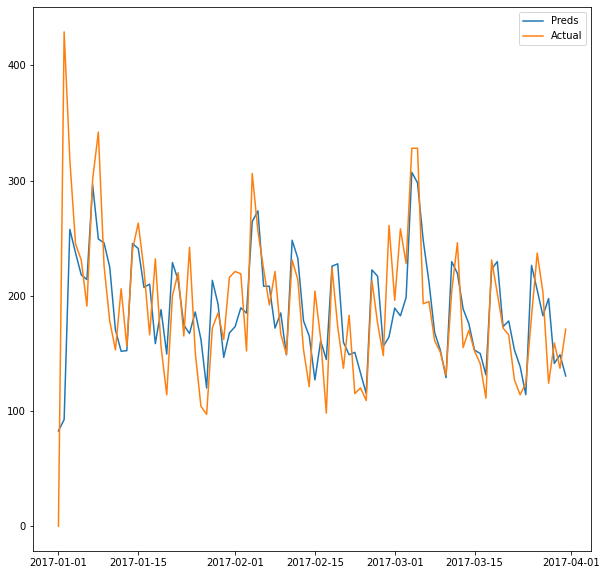

In [573]:
plt.figure(figsize=(10,10))

plt.plot(df_test.index[0:90].to_timestamp(), y_preds.values, label='Preds')

plt.plot(df_test.index[0:90].to_timestamp(), df_test['sales'].values[0:90], label='Actual')

plt.legend()

Events
on_promotion
Holiday Season
Seasonality
Workday
Earthquake


<a id="ARMA-with-Covariates"></a>
## ARIMA with Covariates

In [574]:
dlm_cols = ['Trend','Mon','Tues','Weds',
                'Thurs','Sat','Sun','lag7','nye','oil']

In [575]:
#arima_dlm = auto_arima(df_train['sales'],X=df_train[dlm_cols])

In [576]:
#arima_dlm

In [577]:
arima_dlm = ARIMA(df_train['sales'], exog = df_train[dlm_cols], order = (1,0,1)).fit()

In [578]:
arima_dlm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 1448
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -7200.701
Date:                Mon, 02 Jan 2023   AIC                          14429.402
Time:                        21:53:17   BIC                          14503.293
Sample:                    01-10-2013   HQIC                         14456.978
                         - 12-31-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        258.7039     26.457      9.778      0.000     206.848     310.559
Trend          0.0043      0.014      0.303      0.762      -0.024       0.032
Mon          -48.9609      3.534    -13.853      0.000     -55.888     -42.034
Tues         -73.1225      3.742    -19.542      0.000     -80.456     -65.789
Weds         -80.4299      3.709    -21.687      0.000     -87.699     -73.161
Thurs        -98.8289      3.513    -28.133      0.000    -105.714     -91.944
Sat           -5.1986      2.423     -2.145      0.032      -9.948      -0.449
Sun          -49.8820      3.161    -15.782      0.000     -56.077     -43.687
lag7           0.0069      0.025      0.277      0.782      -0.042       0.056
nye         -149.3232     10.887    -13.716      0.000    -170.661    -127.985
oil           -0.4852      0.227     -2.139      0.032      -0.930      -0.041
ar.L1          0.7691      0.029     26.890      0.000       0.713       0.825
ma.L1         -0.2650      0.039     -6.880      0.000      -0.340      -0.190
sigma2      1221.3795     39.695     30.769      0.000    1143.578    1299.181
===================================================================================
Ljung-Box (L1) (Q):                   0.15   Jarque-Bera (JB):               275.42
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               1.59   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [579]:
y_preds = arima_dlm.predict(start=len(df_train['sales']), end=len(df_train['sales'])+89, 
                            exog= df_test[dlm_cols][0:90])

resids = np.array(df_test['sales'][0:90]) - np.array(y_preds)
        
test_rmse = np.sqrt(np.sum(resids**2)/len(resids))

In [580]:
test_rmse

51.18121082586794

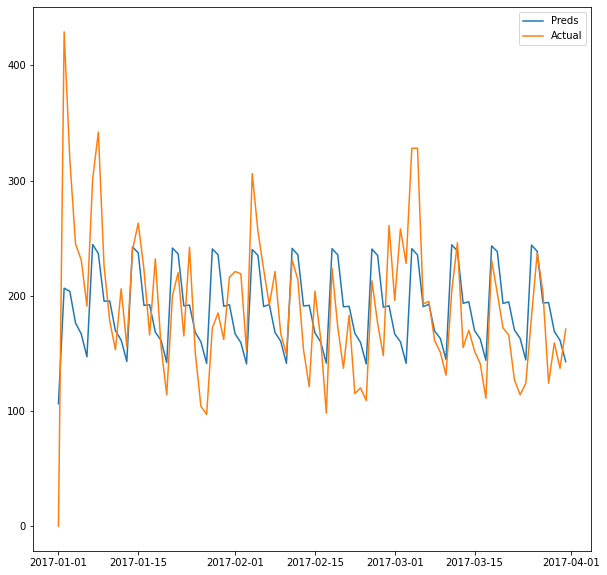

In [581]:
plt.figure(figsize=(10,10))

plt.plot(df_test.index[0:90].to_timestamp(), y_preds.values, label='Preds')

plt.plot(df_test.index[0:90].to_timestamp(), df_test['sales'].values[0:90], label='Actual')

plt.legend()

<a id="OLS-4"></a>
## OLS 4: OLS 3 + Month + Holidays + Promotions

In [582]:
ols4_cols = ['Trend','Mon','Tues','Weds','Thurs','Sat','Sun','lag1','lag2','lag3','lag4',
             'lag5','lag6','lag7','nye','oil','month_2','month_3','month_4','month_5',
             'month_6','month_7','month_8','month_9','month_10','month_11','month_12',
             'wageday','day_after_ny','black_friday','cyber_monday','carnaval',
             'other_holiday','onpromotion']

In [583]:
ols_mod = sm.OLS(df_train['sales'], 
                 sm.add_constant(df_train[ols4_cols]),
                hasconst=True).fit()

In [584]:
ols_mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  sales   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     94.22
Date:                Mon, 02 Jan 2023   Prob (F-statistic):               0.00
Time:                        21:53:17   Log-Likelihood:                -7101.9
No. Observations:                1448   AIC:                         1.427e+04
Df Residuals:                    1413   BIC:                         1.446e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           169.6953     11.514     14.739      0.000     147.110     192.281
Trend             0.0031      0.006      0.534      0.593      -0.008       0.015
Mon             -94.8191      4.559    -20.797      0.000    -103.763     -85.876
Tues           -116.8119      4.472    -26.123      0.000    -125.584    -108.040
Weds           -109.2199      4.701    -23.233      0.000    -118.442     -99.998
Thurs          -112.5914      4.318    -26.076      0.000    -121.061    -104.121
Sat             -50.9951      4.393    -11.609      0.000     -59.612     -42.378
Sun            -107.8989      4.461    -24.185      0.000    -116.651     -99.147
lag1              0.4678      0.025     18.728      0.000       0.419       0.517
lag2              0.1376      0.026      5.210      0.000       0.086       0.189
lag3              0.0780      0.027      2.939      0.003       0.026       0.130
lag4              0.0283      0.026      1.071      0.284      -0.024       0.080
lag5             -0.0253      0.026     -0.965      0.335      -0.077       0.026
lag6             -0.0883      0.026     -3.399      0.001      -0.139      -0.037
lag7             -0.0192      0.024     -0.799      0.425      -0.066       0.028
nye            -189.5941     19.934     -9.511      0.000    -228.698    -150.490
oil              -0.1950      0.080     -2.425      0.015      -0.353      -0.037
month_2          -6.9410      4.514     -1.538      0.124     -15.795       1.913
month_3          -6.1023      4.411     -1.383      0.167     -14.756       2.551
month_4           1.4645      4.446      0.329      0.742      -7.257      10.186
month_5           0.7612      4.528      0.168      0.867      -8.122       9.644
month_6          -3.1074      4.606     -0.675      0.500     -12.142       5.927
month_7          -0.1573      4.589     -0.034      0.973      -9.160       8.845
month_8          -1.6259      4.573     -0.356      0.722     -10.596       7.344
month_9          -2.7730      4.628     -0.599      0.549     -11.852       6.306
month_10         -4.5248      4.615     -0.980      0.327     -13.579       4.529
month_11         -4.3430      4.614     -0.941      0.347     -13.395       4.709
month_12         14.9953      4.640      3.232      0.001       5.893      24.097
wageday          30.9702      3.640      8.507      0.000      23.829      38.112
day_after_ny    205.0503     19.977     10.264      0.000     165.862     244.238
black_friday     -4.5018     19.505     -0.231      0.818     -42.764      33.760
cyber_monday     -7.8149     19.424     -0.402      0.688     -45.919      30.289
carnaval         13.3251     12.144      1.097      0.273     -10.498      37.148
other_holiday    30.4860      6.046      5.043      0.000      18.627      42.345
onpromotion      -0.4890      0.470     -1.040   

In [585]:
y_preds = ols_mod.predict(sm.add_constant(df_test[ols4_cols][0:90]))

resids = np.array(df_test['sales'][0:90]) - np.array(y_preds)
        
test_rmse = np.sqrt(np.sum(resids**2)/len(resids))

In [586]:
test_rmse

38.331773721884595

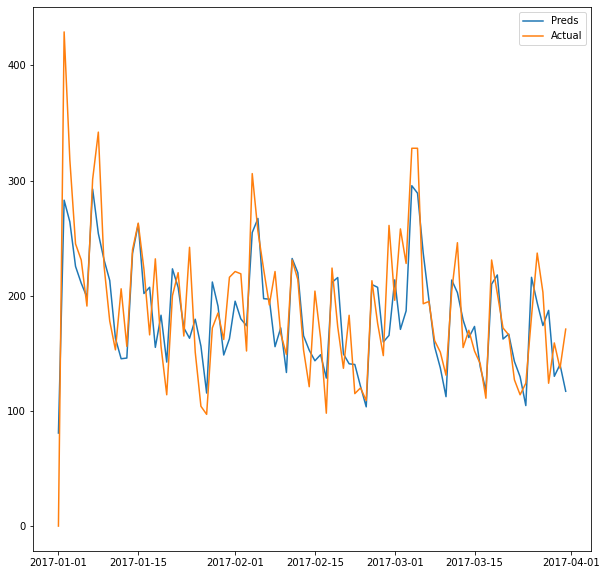

In [587]:
plt.figure(figsize=(10,10))

plt.plot(df_test.index[0:90].to_timestamp(), y_preds.values, label='Preds')

plt.plot(df_test.index[0:90].to_timestamp(), df_test['sales'].values[0:90], label='Actual')

plt.legend()

<a id="hybrid"></a>
## Hybrid Model (1 Data Stream)

In [588]:
#What features do I use for the linear model, and what features do I use for the tree model?

linear_cols = ['Trend','Mon','Tues','Weds','Thurs','Sat','Sun','lag1','lag2','lag3','lag4',
             'lag5','lag6','lag7','nye','oil','month_2','month_3','month_4','month_5',
             'month_6','month_7','month_8','month_9','month_10','month_11','month_12',
             'wageday','day_after_ny','black_friday','cyber_monday','carnaval',
             'other_holiday','onpromotion']

nonlinear_cols = ['Mon','Tues','Weds','Thurs','Sat','Sun','lag1','lag2','lag3','lag4',
             'lag5','lag6','lag7','nye','oil','month_2','month_3','month_4','month_5',
             'month_6','month_7','month_8','month_9','month_10','month_11','month_12',
             'wageday','day_after_ny','black_friday','cyber_monday','carnaval',
             'other_holiday','onpromotion']

In [589]:
linear_model = sm.OLS(df_train['sales'], 
                 sm.add_constant(df_train[linear_cols]),
                hasconst=True).fit()

In [590]:
# hyperparameter tuning for the tree

n_estimators = [100, 200, 300, 400, 500] # number of trees in the random forest
max_features = ['auto', 'sqrt'] # number of features in consideration at every split
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)] # maximum number of levels allowed in each decision tree
min_samples_split = [10, 20, 30, 40, 50] # minimum sample number to split a node
min_samples_leaf = [4,5,6,7,8] # minimum sample number that can be stored in a leaf node
bootstrap = [True, False] # method used to sample data points

random_grid = {'n_estimators': n_estimators,

'max_features': max_features,

'max_depth': max_depth,

'min_samples_split': min_samples_split,

'min_samples_leaf': min_samples_leaf,

'bootstrap': bootstrap}

In [591]:
## Importing Random Forest Classifier from the sklearn.ensemble
#rf = RandomForestRegressor()

In [592]:
#nonlinear_model = RandomizedSearchCV(estimator = rf,param_distributions = random_grid,
#              n_iter = 100, cv = 5, verbose=2, random_state=35, n_jobs = -1)

In [593]:
#nonlinear_model.fit(df_train[nonlinear_cols], linear_model.resid)



In [594]:
#print ('Random grid: ', random_grid, '\n')
# print the best parameters
#print ('Best Parameters: ', nonlinear_model.best_params_, ' \n')

In [595]:
nonlinear_model = RandomForestRegressor(n_estimators=100, min_samples_split=20,
                                       min_samples_leaf=4, max_features='sqrt',
                                       max_depth = 120, bootstrap=False)

In [596]:
nonlinear_model.fit(df_train[nonlinear_cols], linear_model.resid)

RandomForestRegressor(bootstrap=False, max_depth=120, max_features='sqrt',
                      min_samples_leaf=4, min_samples_split=20)

In [597]:
y_preds = linear_model.predict(sm.add_constant(df_test[linear_cols][0:90]))

y_preds = y_preds + nonlinear_model.predict(df_test[nonlinear_cols][0:90])

resids = np.array(df_test['sales'][0:90]) - np.array(y_preds)
        
test_rmse = np.sqrt(np.sum(resids**2)/len(resids))

In [598]:
test_rmse

36.06860616234277

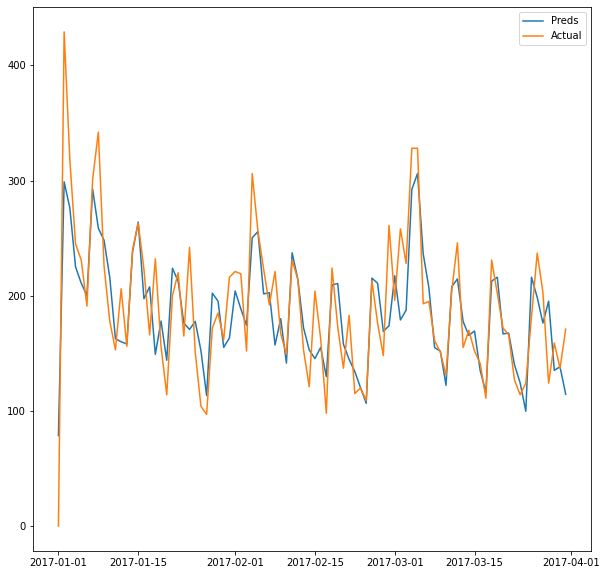

In [599]:
plt.figure(figsize=(10,10))

plt.plot(df_test.index[0:90].to_timestamp(), y_preds.values, label='Preds')

plt.plot(df_test.index[0:90].to_timestamp(), df_test['sales'].values[0:90], label='Actual')

plt.legend()

<a id="full"></a>
## Expansion to Full Dataset

In [600]:
#workaround: Constant term needs to be added to this list as sm.add_constant is not working
#when predicting over only 15 data points (some holiday events are 0 columns, making
#add_constant not add an intercept)

linear_cols = ['const','Trend','Mon','Tues','Weds','Thurs','Sat','Sun','lag1','lag2','lag3','lag4',
             'lag5','lag6','lag7','nye','oil','month_2','month_3','month_4','month_5',
             'month_6','month_7','month_8','month_9','month_10','month_11','month_12',
             'wageday','day_after_ny','black_friday','cyber_monday','carnaval',
             'other_holiday','onpromotion']

In [601]:

#
def develop_model(X_train, y_train, X_test):
    
    #create trend variable for each data stream
    
    X_train['Trend'] = [x for x in range(len(X_train))]
    X_test['Trend'] = [x for x in range(len(X_train), len(X_train) + len(X_test))]
    
    #workaround - there are some empty columns in X_test for holidays that don't occur
    #in that time range, and it is messing up add_const
    X_train['const'] = 1
    X_test['const'] = 1
    
    linear_model = sm.OLS(y_train, 
                 X_train[linear_cols],
                hasconst=True).fit()
    
    nonlinear_model = RandomForestRegressor(n_estimators=100, min_samples_split=20,
                                       min_samples_leaf=4, max_features='sqrt',
                                       max_depth = 120, bootstrap=False)
    
    nonlinear_model.fit(X_train[nonlinear_cols], linear_model.resid)
    
    #just do naive lags for now
    #iterate through to produce lags
    #for i in range(len(X_test)):
        
    #    y_pred_i = linear_model.predict(X_test[linear_cols])
    #    y_pred_i = y_preds + nonlinear_model.predict(X_test[nonlinear_cols])
        
    #    X
    
    y_preds = linear_model.predict(X_test[linear_cols])

    y_preds = y_preds + nonlinear_model.predict(X_test[nonlinear_cols])
    
    return(y_preds)



In [602]:
train[nonlinear_cols].head()

,Mon,Tues,Weds,Thurs,Sat,Sun,lag1,lag2,lag3,lag4,lag5,lag6,lag7,nye,oil,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,wageday,day_after_ny,black_friday,cyber_monday,carnaval,other_holiday,onpromotion
2013-01-10,0,0,1,0,0,0,2.0,2.0,0.0,2.0,5.0,3.0,3.0,0,93.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-10,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,93.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-10,0,0,1,0,0,0,1.0,3.0,1.0,0.0,3.0,3.0,0.0,0,93.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-10,0,0,1,0,0,0,1186.0,1029.0,1158.0,407.0,1160.0,953.0,919.0,0,93.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2013-01-10,0,0,1,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,93.81,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [603]:
#larger_train = train[train['store_nbr'] == 1]
#larger_test = test[test['store_nbr'] == 1]

larger_train = train
larger_test = test

#larger_train = train[(train['store_nbr'] == 1) & (train['date'] < '08-01-2017')]
#larger_test = test[(test['store_nbr'] == 1) & (test['date'] >= '08-01-2017')]

In [604]:
import warnings
warnings.filterwarnings('ignore')

In [605]:
%%time

y_preds_df = pd.DataFrame(None, columns=['date','store_nbr','family','y_preds'])

for j in np.unique(larger_train['store_nbr']):
    for i in np.unique(larger_train['family']):
        ts_train = larger_train[(larger_train['family'] == i) & (larger_train['store_nbr'] == j)]
        ts_test = larger_test[(larger_test['family'] == i) & (larger_test['store_nbr'] == j)]
        
    
        y_preds = develop_model(ts_train.drop('sales', axis=1), ts_train['sales'], 
                            ts_test)#.drop('sales', axis=1))
    
        temp_data = pd.DataFrame(data=np.array([ts_test['date'],ts_test['store_nbr'],
                          ts_test['family'], y_preds],dtype='object').T,
                            columns=['date','store_nbr','family','y_preds'])
    
        y_preds_df = pd.concat([y_preds_df, temp_data])
                        

CPU times: user 18min 8s, sys: 9min 10s, total: 27min 18s
Wall time: 16min 24s


In [606]:

warnings.filterwarnings('default')

In [607]:
final_df = test.reset_index(drop=True).merge(y_preds_df, how='inner',
                                  on=['date','store_nbr','family'],
                                 )[['id','y_preds']]

final_df.columns = ['id','sales']

In [608]:
final_df.to_csv('submission.csv', index=False)

In [611]:
pd.read_csv("./submission.csv")


,id,sales
0,3000888,5.222197
1,3000889,0.000000
2,3000890,6.301138
3,3000891,2180.390419
4,3000892,0.166573
...,...,...
28507,3029395,324.367044
28508,3029396,115.596904
28509,3029397,1340.011573
28510,3029398,156.232348


In [612]:
pd.read_csv('../input/store-sales-time-series-forecasting/test.csv')

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0
...,...,...,...,...,...
28507,3029395,2017-08-31,9,POULTRY,1
28508,3029396,2017-08-31,9,PREPARED FOODS,0
28509,3029397,2017-08-31,9,PRODUCE,1
28510,3029398,2017-08-31,9,SCHOOL AND OFFICE SUPPLIES,9
